## Objective
 - To write code base necessary to do data analysis and produce a machine learning model to perform topic modelling and sentiment analysis
###  Required modules at the minimum:
1. Data exploration 
2. Pre-processing 
3. Visualisations.


### Import liberaries

In [138]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
import pandas as pd
import statistics
import string
import nltk
import warnings
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn import datasets
import sys, os


### Load Data

In [2]:
sys.path.append(os.path.abspath(os.path.join('../..')))

In [3]:
raw_data = pd.read_csv('../data/processed_tweet_data.csv')

### 1. Pre-processing

#### 1.1 Check The size of The Data

In [4]:
raw_data.shape

(24625, 15)

#### 1.2 Explore the first and the last values of the data

In [5]:
raw_data.head(3)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
0,Fri Apr 22 22:20:18 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @nikitheblogger: Irre: Annalena Baerbock sa...,0.0,0.0,de,2356,355,McMc74078966,3,12,NaN,[],"[{'screen_name': 'nikitheblogger', 'name': 'Ne...",NaN
1,Fri Apr 22 22:19:16 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @sagt_mit: Merkel schaffte es in 1 Jahr 1 M...,0.0,0.0,de,1985,505,McMc74078966,3,12,NaN,[],"[{'screen_name': 'sagt_mit', 'name': 'Sie sagt...",NaN
2,Fri Apr 22 22:17:28 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT @Kryptonoun: @WRi007 Pharma in Lebensmittel...,0.0,0.0,de,16,4,McMc74078966,3,12,NaN,[],"[{'screen_name': 'Kryptonoun', 'name': 'Krypto...",NaN


In [6]:
raw_data.tail(3)

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
24622,Fri Apr 22 14:44:35 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...",RT @Parthtiwari25: Gujarat Congress MLA arrest...,0.0,0.0,en,1025,203,kitukalesatya,706,643,NaN,[],"[{'screen_name': 'Parthtiwari25', 'name': 'Par...",NaN
24623,Fri Apr 22 14:44:08 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...",RT @news24tvchannel: CM नीतीश कुमार ने तेजस्वी...,0.0,0.0,hi,3735,301,kitukalesatya,706,643,False,[],"[{'screen_name': 'news24tvchannel', 'name': 'N...",NaN
24624,Fri Apr 22 14:43:01 +0000 2022,"<a href=""http://twitter.com/download/iphone"" r...",RT @suvegrathi: भगवान और खुदा आपस में बात कर र...,0.0,0.0,hi,10,12,kitukalesatya,706,643,False,[],"[{'screen_name': 'suvegrathi', 'name': 'Suveg ...",NaN


#### 1.3 Check the columns ans their data type

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24625 entries, 0 to 24624
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          24625 non-null  object 
 1   source              24625 non-null  object 
 2   original_text       24625 non-null  object 
 3   polarity            24625 non-null  float64
 4   subjectivity        24625 non-null  float64
 5   lang                24625 non-null  object 
 6   favorite_count      24625 non-null  int64  
 7   retweet_count       24625 non-null  int64  
 8   original_author     24625 non-null  object 
 9   followers_count     24625 non-null  int64  
 10  friends_count       24625 non-null  int64  
 11  possibly_sensitive  9854 non-null   object 
 12  hashtags            24625 non-null  object 
 13  user_mentions       24625 non-null  object 
 14  place               15731 non-null  object 
dtypes: float64(2), int64(4), object(9)
memory usage: 2.8+

#### 1.4 Check for missed values

In [8]:
raw_data.isna().mean()

created_at            0.000000
source                0.000000
original_text         0.000000
polarity              0.000000
subjectivity          0.000000
lang                  0.000000
favorite_count        0.000000
retweet_count         0.000000
original_author       0.000000
followers_count       0.000000
friends_count         0.000000
possibly_sensitive    0.599838
hashtags              0.000000
user_mentions         0.000000
place                 0.361178
dtype: float64

- from the resul we can see that column "possibly_sensitive" contains approximatly 60% of missed values and the column "place" contains aproximatlly 40% of missed values.
- Since those comumns has messing values more than 30%, I decide to drop them.

In [9]:
sys.path.append(os.path.abspath(os.path.join('..')))
from clean_tweets_dataframe import Clean_Tweets

In [10]:
Clean_t = Clean_Tweets()

#### 1.5 Cleaning

**Check and manage(Drop) duplications**

In [48]:
raw_data.duplicated().sum()

0

- ***The Result shows the data has no duplicated values***

In [139]:
df = raw_data.copy()

**Remove non english tweets**

In [140]:
df = Clean_t.remove_non_english_tweets(tweets)

**Remove Links**

In [141]:
df = Clean_t.remove_links(df)

**Remove special characters**

In [142]:
df = Clean_t.remove_special_characters(df)

In [130]:
df.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,user_mentions,place
38,Fri Apr 22 22:17:05 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT NorthstarCharts The year yield is tell...,0.16,0.540000,en,188,43,davideiacovozzi,18,55,False,"[{'text': 'gold', 'indices': [116, 121]}, {'te...","[{'screen_name': 'NorthstarCharts', 'name': 'N...",NaN
39,Fri Apr 22 13:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT MichaelAArouet German y mortgage rate w...,0.15,0.175000,en,179,32,davideiacovozzi,18,55,False,[],"[{'screen_name': 'MichaelAArouet', 'name': 'Mi...",NaN
41,Fri Apr 22 06:10:34 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT goldseek When,0.00,0.000000,en,193,26,davideiacovozzi,18,55,False,[],"[{'screen_name': 'goldseek', 'name': 'Peter ⚒ ...",NaN
42,Thu Apr 21 17:22:09 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT charliebilello The year mortgage rate ...,0.00,0.183333,en,620,213,davideiacovozzi,18,55,False,[],"[{'screen_name': 'charliebilello', 'name': 'Ch...",NaN
43,Thu Apr 21 10:32:26 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT biancoresearch Rates rise until something...,-0.40,0.400000,en,1787,417,davideiacovozzi,18,55,False,[],"[{'screen_name': 'biancoresearch', 'name': 'Ji...",NaN


**Remove Hashtags**

In [143]:
df["hashtags"] = df["hashtags"].apply((lambda x: Clean_t.get_element_from_json(x, 'text', '#')))
df["hashtags"][:3]

38    [#gold, #gold, #gold]
39                       []
41                       []
Name: hashtags, dtype: object

In [144]:
df["hashtags"] = df["hashtags"].apply(Clean_t.array_to_string)
df["hashtags"][:10]

38    #gold, #gold, #gold
39                       
41                       
42                       
43                       
44                 #bonds
45                       
46                       
47                       
48                       
Name: hashtags, dtype: object

In [145]:
new_df = pd.DataFrame(columns=['hashtags'])
new_df['hashtags'] = df.original_text.apply(Clean_t.find_hashtags)
new_df[:5]

,hashtags
38,"[#gold, #silver, #crypto]"
39,[]
41,[]
42,[]
43,[]


In [146]:
df["hashtags_in_tweets"] = new_df["hashtags"].apply(Clean_t.array_to_string)
df["hashtags_in_tweets"][:10]

38    #gold, #silver, #crypto
39                           
41                           
42                           
43                           
44                     #bonds
45                           
46                           
47                           
48                           
Name: hashtags_in_tweets, dtype: object

In [94]:
df.original_text[:5]

38    RT  NorthstarCharts  The    year yield is tell...
39    RT  MichaelAArouet  German   y mortgage rate w...
41                                 RT  goldseek  When  
42    RT  charliebilello  The    year mortgage rate ...
43    RT  biancoresearch  Rates rise until something...
Name: original_text, dtype: object

- **get UserNames mentions**

In [147]:
df["screen_name"] = df["user_mentions"].apply(
    (lambda x: Clean_t.get_element_from_json(x, 'screen_name', "@",)))
df["screen_name"][:3]

38    [@NorthstarCharts]
39     [@MichaelAArouet]
41           [@goldseek]
Name: screen_name, dtype: object

In [148]:
df["screen_name"] = df["screen_name"].apply(Clean_t.array_to_string)
df["screen_name"][:5]

38    @NorthstarCharts
39     @MichaelAArouet
41           @goldseek
42     @charliebilello
43     @biancoresearch
Name: screen_name, dtype: object

- **I have extracted user_name(screen_name) i drope them here.**

In [149]:
df1=df.copy()

In [150]:
df1.drop(['user_mentions'], axis=1, inplace=True)


**Device based manupulation**
- **get usernames that are mentiond in original_text**

In [151]:
df1["device"] = df1["source"].apply(Clean_t.get_device_name)
df1["device"][:10]

38    Twitter for Android
39    Twitter for Android
41    Twitter for Android
42    Twitter for Android
43    Twitter for Android
44    Twitter for Android
45    Twitter for Android
46    Twitter for Android
47    Twitter for Android
48    Twitter for Android
Name: device, dtype: object

- **Hince i get divice name i dont need source column**

In [152]:
df1.head()

,created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,place,hashtags_in_tweets,screen_name,device
38,Fri Apr 22 22:17:05 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT NorthstarCharts The year yield is tell...,0.16,0.540000,en,188,43,davideiacovozzi,18,55,False,"#gold, #gold, #gold",NaN,"#gold, #silver, #crypto",@NorthstarCharts,Twitter for Android
39,Fri Apr 22 13:44:53 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT MichaelAArouet German y mortgage rate w...,0.15,0.175000,en,179,32,davideiacovozzi,18,55,False,,NaN,,@MichaelAArouet,Twitter for Android
41,Fri Apr 22 06:10:34 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT goldseek When,0.00,0.000000,en,193,26,davideiacovozzi,18,55,False,,NaN,,@goldseek,Twitter for Android
42,Thu Apr 21 17:22:09 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT charliebilello The year mortgage rate ...,0.00,0.183333,en,620,213,davideiacovozzi,18,55,False,,NaN,,@charliebilello,Twitter for Android
43,Thu Apr 21 10:32:26 +0000 2022,"<a href=""http://twitter.com/download/android"" ...",RT biancoresearch Rates rise until something...,-0.40,0.400000,en,1787,417,davideiacovozzi,18,55,False,,NaN,,@biancoresearch,Twitter for Android


In [153]:
df1.drop(['source'], axis=1, inplace=True)

In [154]:
df1 = Clean_t.to_lower(df1) #lower case all the data set

In [155]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24625 entries, 0 to 24624
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          24625 non-null  object 
 1   source              24625 non-null  object 
 2   original_text       24625 non-null  object 
 3   polarity            24625 non-null  float64
 4   subjectivity        24625 non-null  float64
 5   lang                24625 non-null  object 
 6   favorite_count      24625 non-null  int64  
 7   retweet_count       24625 non-null  int64  
 8   original_author     24625 non-null  object 
 9   followers_count     24625 non-null  int64  
 10  friends_count       24625 non-null  int64  
 11  possibly_sensitive  9854 non-null   object 
 12  hashtags            24625 non-null  object 
 13  user_mentions       24625 non-null  object 
 14  place               15731 non-null  object 
dtypes: float64(2), int64(4), object(9)
memory usage: 3.5+

In [156]:
print("The number of missing value(s): {}".format(df1.isnull().sum().sum()))
print("Columons having columns value: {}".format( df1.columns[df1.isnull().any()]))

The number of missing value(s): 16087
Columons having columns value: Index(['possibly_sensitive', 'place'], dtype='object')


**Fill missing values**
1. assuming possibly_sensitive has False and True values
2. Place True

In [157]:
df1["possibly_sensitive"].fillna(False, inplace=True) 
df1["place"].fillna(" ", inplace=True)

In [158]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16472 entries, 38 to 24622
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          16472 non-null  object 
 1   original_text       16472 non-null  object 
 2   polarity            16472 non-null  float64
 3   subjectivity        16472 non-null  float64
 4   lang                16472 non-null  object 
 5   favorite_count      16472 non-null  int64  
 6   retweet_count       16472 non-null  int64  
 7   original_author     16472 non-null  object 
 8   followers_count     16472 non-null  int64  
 9   friends_count       16472 non-null  int64  
 10  possibly_sensitive  16472 non-null  bool   
 11  hashtags            16472 non-null  object 
 12  place               16472 non-null  object 
 13  hashtags_in_tweets  16472 non-null  object 
 14  screen_name         16472 non-null  object 
 15  device              16472 non-null  object 
dtypes: 

#### - fix the data type

In [160]:
df1 = Clean_t.convert_to_string(df1)

date convert

In [161]:
print(f"The first row created time before conversion {df1.created_at[0]}")
df1 = Clean_t.convert_to_datetime(tweets)
print(f"The first row created time after conversion {df1.created_at[0]}")

KeyError: 0

**convert to numbers**

In [162]:
df1 = Clean_t.convert_to_numbers(df1)

**convert possible_sansitive to boolean**

In [164]:
df1 = Clean_t.convert_to_boolean(df1)

**Convert possible_sansitive column to boolean**

In [165]:
df1 = Clean_t.convert_to_numbers(df1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16472 entries, 38 to 24622
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   created_at          16472 non-null  object 
 1   original_text       16472 non-null  string 
 2   polarity            16472 non-null  float64
 3   subjectivity        16472 non-null  float64
 4   lang                16472 non-null  object 
 5   favorite_count      16472 non-null  int64  
 6   retweet_count       16472 non-null  int64  
 7   original_author     16472 non-null  string 
 8   followers_count     16472 non-null  int64  
 9   friends_count       16472 non-null  int64  
 10  possibly_sensitive  16472 non-null  bool   
 11  hashtags            16472 non-null  string 
 12  place               16472 non-null  string 
 13  hashtags_in_tweets  16472 non-null  string 
 14  screen_name         16472 non-null  string 
 15  device              16472 non-null  string 
dtypes: 

**save cleaned data**

In [166]:
df1.to_csv(r'my_clean_data.csv', index=False, header=True)

### 2. Data exploration

In [168]:
clean_tweets = pd.read_csv("my_clean_data.csv")

In [ ]:
print('Count of columns in the data is:  ', len(tweets.columns))
print('Count of rows in the data is:  ', len(tweets))

In [ ]:
tweets.groupby("original_author").size().agg( ['count', 'min', 'max', 'mean', 'median'])

In [ ]:
twetter_users = tweets.groupby("original_author").size()
twetter_users.nlargest(5)

In [ ]:
tweets.groupby("device").size().agg( ['count', 'min', 'max', 'mean', 'median'])

In [ ]:
tweets["score"] = tweets["polarity"].apply(ct.polarity_category)
tweets.groupby("score")["polarity"].count()

In [ ]:
tweet_sent = tweets.groupby(['score']).sum()[["retweet_count", "favorite_count", "followers_count", "friends_count"]]
tweet_sent

In [ ]:
tweets["subjectivity_score"] = tweets["subjectivity"].apply(
    ct.subjectivity_category)
tweets.groupby("subjectivity_score")["subjectivity"].count()

In [ ]:
tweet_sent = tweets.groupby(['subjectivity_score']).sum(
)[["retweet_count", "favorite_count", "followers_count", "friends_count"]]
tweet_sent

In [ ]:
tweets_df = pd.DataFrame(columns=['hashtags', 'hashtags_in_tweets'])
tweets_df['hashtags'] = tweets['hashtags'].apply(ct.string_to_array)
tweets_df['hashtags_in_tweets'] = tweets['hashtags_in_tweets'].apply(
    ct.string_to_array)
tweets_df[:4]

- follower based

In [39]:
feed_count = raw_data['followers_count'].value_counts()
feed_count

1        252
9        200
40       200
24       180
0        157
        ... 
7895      20
40306     20
181       10
15654     10
1207      10
Name: followers_count, Length: 458, dtype: int64

- freinds based

In [40]:
feed_count = raw_data['friends_count'].value_counts()
feed_count

0        402
36       257
4        197
1        188
44       176
        ... 
7892      20
652       20
4729      20
41866     20
640       10
Name: friends_count, Length: 419, dtype: int64

- see the top authors

In [45]:
feed_count = raw_data['original_author'].value_counts()
feed_count

SurabAliSekh3      50
ozguryurduozler    50
AlecH34748141      50
ThHappyHawaiian    50
pastexpiry         50
                   ..
ArchibaldBlume      7
RulerDeadly         6
electriccalcul1     2
sarahtran1240       1
indrase41218989     1
Name: original_author, Length: 500, dtype: int64

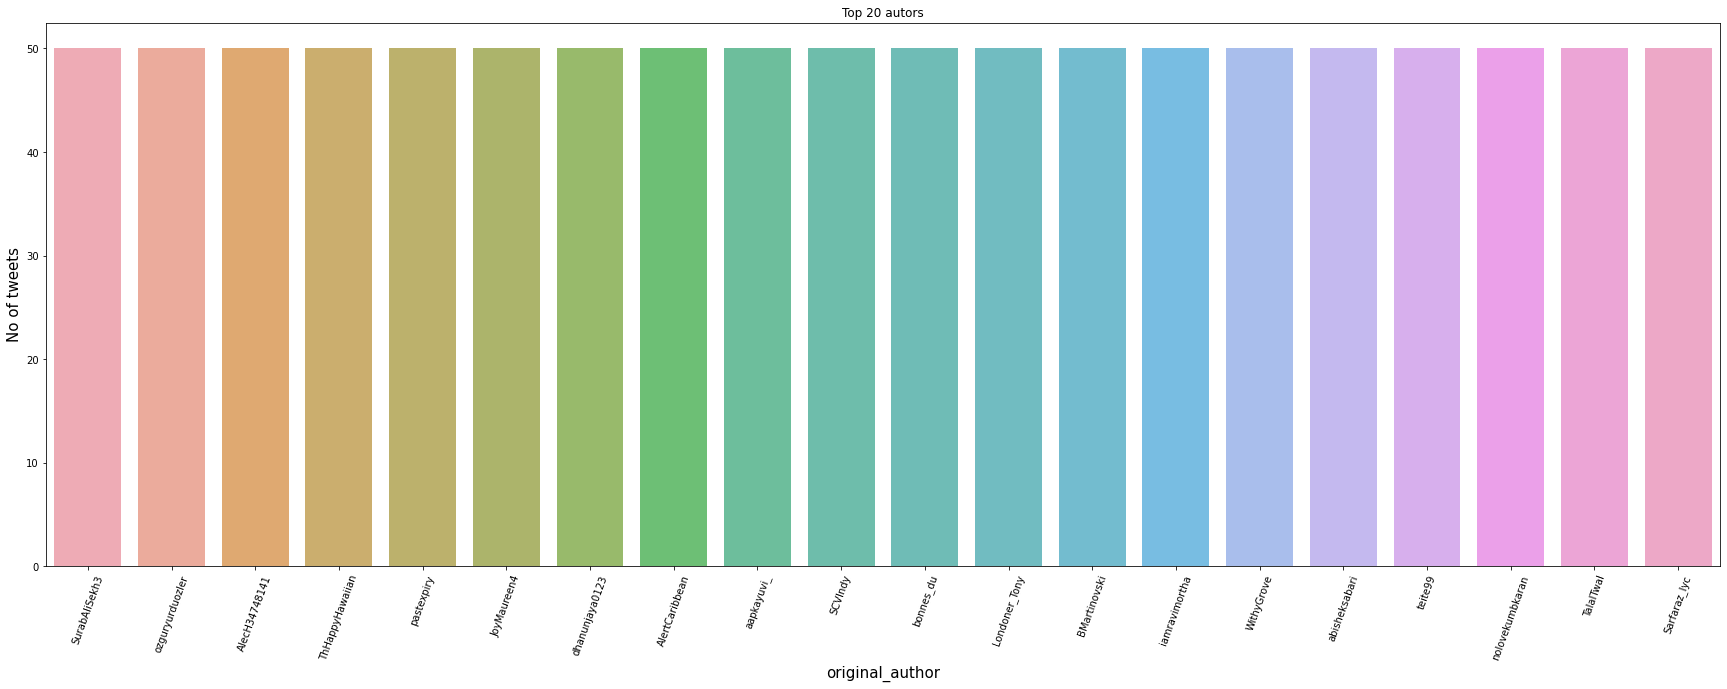

In [47]:
feed_count = feed_count[:100,]
plt.figure(figsize=(30,10))
sns.barplot(feed_count.index , feed_count.values, alpha = 0.8)
plt.title("Top 20 autors")
plt.ylabel('No of tweets', fontsize = 15)
plt.xlabel('original_author', fontsize = 15)
plt.xticks(rotation=70)
plt.show()

### 1. Explore The Data